In [1]:
import os
import sys
sys.path.insert(0, '/home/zzhuang/PseCo')
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image, to_tensor
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from PIL import Image
import numpy as np
import tqdm
import albumentations as A
import torch.nn as nn
import torchvision
import torchvision.ops as vision_ops
from ops.foundation_models.segment_anything.utils.amg import batched_mask_to_box
from ops.ops import _nms, plot_results
plt.rcParams["figure.dpi"] = 300
import json
torch.cuda.set_device(0)
torch.autograd.set_grad_enabled(False)
!gpustat

121.pami.group            Mon Dec 11 20:33:23 2023  515.105.01
[0] NVIDIA A100-PCIE-40GB | 27°C,   0 % |  2114 / 40960 MB |
[1] NVIDIA A100-PCIE-40GB | 27°C,   0 % | 21772 / 40960 MB | yfyuan(10277M) yfyuan(10927M)
[2] NVIDIA A100-PCIE-40GB | 39°C,   7 % |  9581 / 40960 MB | zhengxin(9009M)
[3] NVIDIA A100-PCIE-40GB | 69°C,  97 % | 26783 / 40960 MB | zhengxin(26215M)


In [3]:
from ops.foundation_models.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor, build_sam, build_sam_vit_b, build_sam_vit_h, build_sam_vit_l

sam = build_sam_vit_h().cuda().eval()
# sam = build_sam_vit_l().cuda().eval()
# sam = build_sam_vit_b().cuda().eval()

In [4]:
def read_image(fname):
    img = Image.open(f'/home/zzhuang/PseCo/data/fsc147/images_384_VarV2/{fname}')
    transform = A.Compose([
        A.LongestMaxSize(1024),
        A.PadIfNeeded(1024, border_mode=0, position=A.PadIfNeeded.PositionType.TOP_LEFT),
    ])
    img = Image.fromarray(transform(image=np.array(img))['image'])
    return img

In [5]:
# all_data = torch.load('/home/zzhuang/PseCo/data/fsc147/sam/all_data_vitb.pth', map_location='cpu')
all_data = torch.load('/home/zzhuang/PseCo/data/fsc147/sam/all_data_vith.pth', map_location='cpu')
# all_data = torch.load('/home/zzhuang/PseCo/data/fsc147/sam/all_data_vitl.pth', map_location='cpu')
segment_anthing_data = torch.load('/home/zzhuang/PseCo/data/fsc147/sam/segment_anything_data_vith.pth', map_location='cpu')

In [6]:
for fname in tqdm.tqdm(all_data):
    target = all_data[fname]
    target['image_id'] = fname
    if fname in segment_anthing_data:
        target['segment_anything'] = segment_anthing_data[fname]
    transform = A.Compose([
        A.LongestMaxSize(256),
        A.PadIfNeeded(256, 256, border_mode=0, position=A.PadIfNeeded.PositionType.TOP_LEFT),
    ])
    mask = Image.fromarray(
        transform(image=np.ones((target['height'], target['width'])).astype(np.uint8) * 255)['image'])
    mask = np.array(mask) > 128
    target['mask'] = torch.from_numpy(mask).reshape(1, 1, 256, 256).bool().float()

100%|█████████████████████████████████████| 6054/6054 [00:05<00:00, 1209.96it/s]


In [7]:
all_image_list = {'train': [], 'val': [], 'test': []}
for fname in all_data:
    if all_data[fname]['split'] == 'train':
        if (all_data[fname]['annotations']['points'].size(0) + all_data[fname]['segment_anything']['pred_points'].size(
                0)) != 0:
            all_image_list[all_data[fname]['split']].append(fname)
    else:
        all_image_list[all_data[fname]['split']].append(fname)

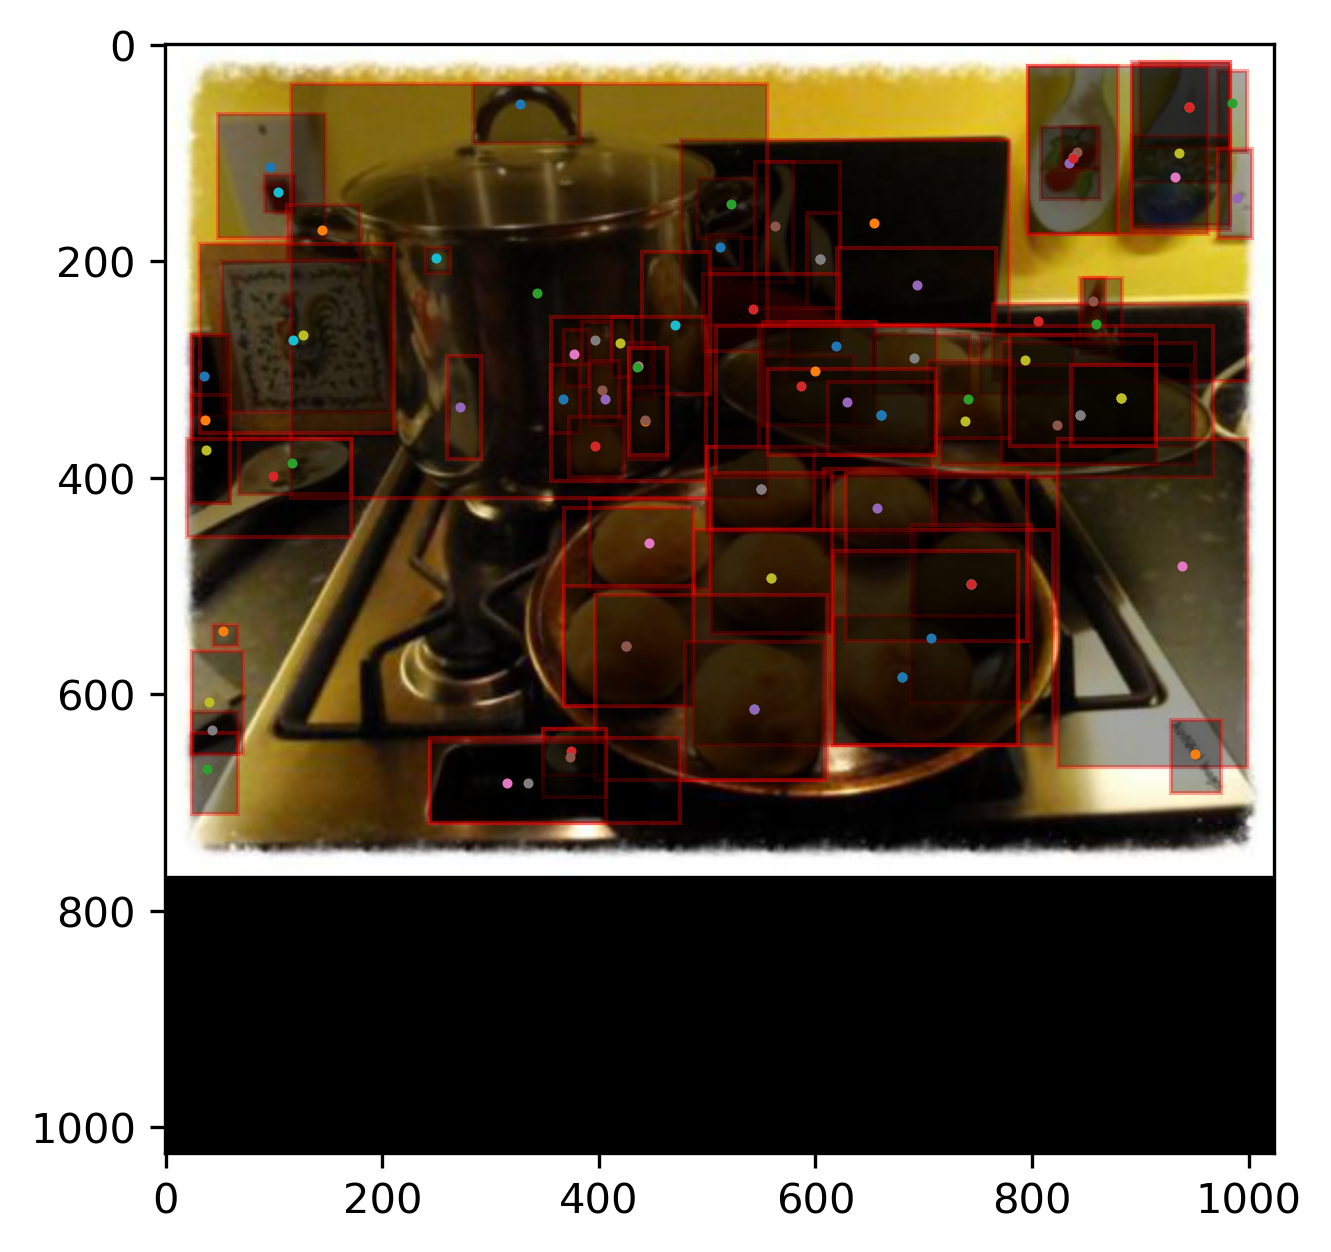

In [8]:
fname = all_image_list['train'][3]
plot_results(read_image(fname),
            #  bboxes=all_data[fname]['annotations']['boxes'],
            #  points=all_data[fname]['annotations']['points'],
             bboxes=all_data[fname]['segment_anything']['pred_boxes'],
             points=all_data[fname]['segment_anything']['pred_points'],
             )

In [9]:
def extract_heatmap(points, sigma=2):
    scale = 4
    # sigma = 2
    if not isinstance(sigma, torch.Tensor):
        sigma = torch.ones(len(points)).cuda() * sigma
    points = points / scale
    points = points.long().float()
    # x = torch.arange(0, 256, 1).cuda() + 0.5
    # y = torch.arange(0, 256, 1).cuda() + 0.5
    x = torch.arange(0, 256, 1).cuda()
    y = torch.arange(0, 256, 1).cuda()
    x, y = torch.meshgrid(x, y, indexing='xy')
    x, y = x.unsqueeze(0), y.unsqueeze(0)
    heatmaps = torch.zeros(1, 1, 256, 256).cuda()
    for indices in torch.arange(len(points)).split(256):
        mu_x, mu_y = points[indices, 0].view(-1, 1, 1), points[indices, 1].view(-1, 1, 1)
        heatmaps_ = torch.exp(- ((x - mu_x) ** 2 + (y - mu_y) ** 2) / (2 * sigma[indices].view(-1, 1, 1) ** 2))
        heatmaps_ = torch.max(heatmaps_, dim=0).values
        heatmaps_ = heatmaps_.reshape(1, 1, 256, 256)
        heatmaps = torch.maximum(heatmaps, heatmaps_)
    return heatmaps.float()

In [10]:
def create_heatmap(fname):
    t = all_data[fname]
    points = torch.cat([t['annotations']['points'].cuda(), t['segment_anything']['pred_points'].cuda(), ])
    st = len(t['annotations']['points'].cuda())
    min_sigma = 2.
    sigma = torch.ones(len(points)).cuda() * min_sigma
    for i in range(len(t['segment_anything']['pred_points'])):
        from ops.ops import gaussian_radius
        import math
        bbox = t['segment_anything']['pred_boxes'][i] / 4
        h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
        radius = gaussian_radius((math.ceil(h), math.ceil(w)))
        radius = max(0, int(radius))
        sigma_ = (2 * radius + 1) / 6.0
        sigma_ = max(sigma_, min_sigma)
        sigma[st + i] = sigma_
    heatmaps = extract_heatmap(points, sigma)
    return heatmaps

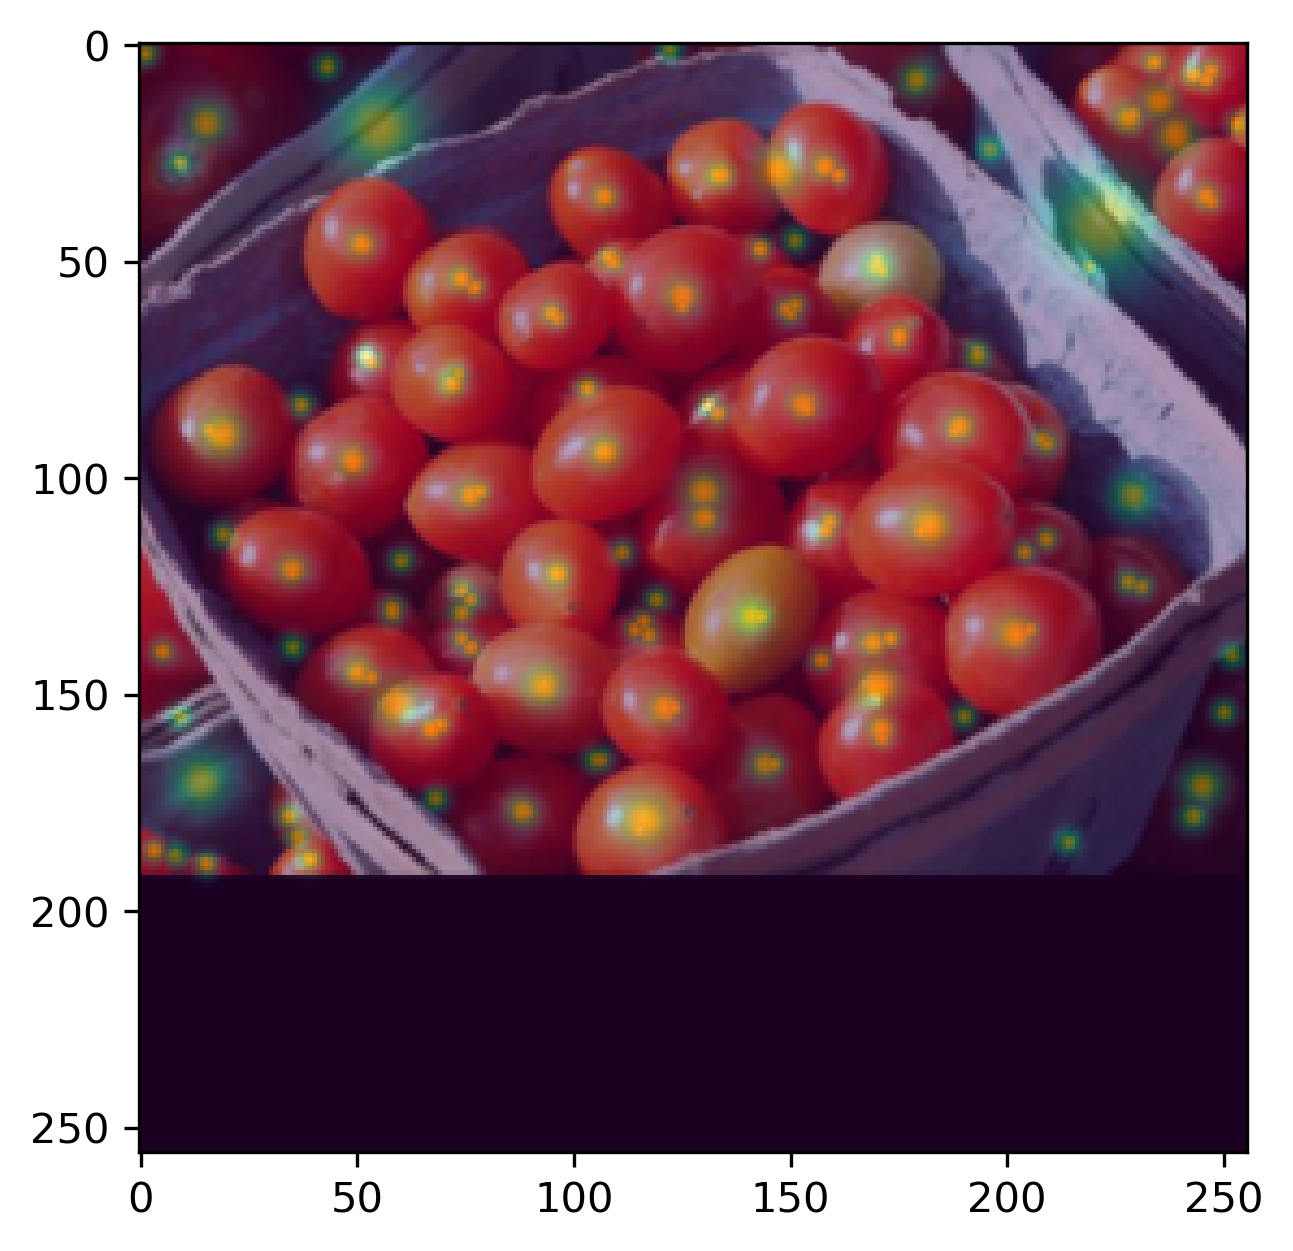

In [11]:
fname = all_image_list['train'][15]
heatmaps = create_heatmap(fname)
plt.imshow(read_image(fname).resize((256, 256)))
plt.imshow(heatmaps[:, 0].squeeze().cpu(), alpha=0.4)

In [18]:
from ops.loggerx import LoggerX
from ops.ops import convert_to_cuda

logger = LoggerX(save_root=None, print_freq=10)

from models import PointDecoder

point_mask_decoder = PointDecoder(sam).cuda()

logger.modules = [point_mask_decoder]
optimizer = torch.optim.AdamW(list(point_mask_decoder.parameters()), lr=0.0001, weight_decay=0.0)

max_iter = 50000
acc_grd_step = 1

from ops.grad_scaler import NativeScalerWithGradNormCount
amp = True
scaler = NativeScalerWithGradNormCount(amp=amp)

bs = 32
train_indices = torch.randint(0, len(all_image_list['train']), (max_iter * bs, )).split(bs)
n_iter = 0

In [25]:
for n_iter, _indices in enumerate(train_indices):

    targets = [all_data[all_image_list['train'][i]] for i in _indices]
    targets = convert_to_cuda(targets)

    point_mask_decoder.train()

    with torch.autograd.set_grad_enabled(True) and torch.autocast(device_type='cuda', enabled=amp):

        pred_heatmaps = point_mask_decoder(torch.cat([t['features'] for t in targets]))['pred_heatmaps']
        heatmaps = torch.cat([create_heatmap(t['image_id']) for t in targets])
        masks = torch.cat([t['mask'] for t in targets]).flatten(1)
        # loss = vision_ops.sigmoid_focal_loss(pred_heatmaps, heatmaps, reduction='mean')
        # loss = F.binary_cross_entropy_with_logits(pred_heatmaps, heatmaps, reduction='mean')
        loss = F.mse_loss(pred_heatmaps, heatmaps, reduction='none').flatten(1)
        loss = ((loss * masks).sum(1) / (1e-5 + masks.sum(1))).mean()

        update_params = (n_iter % acc_grd_step == 0)
        loss = loss / acc_grd_step
        scaler(loss, optimizer=optimizer, update_grad=update_params)

    if (n_iter + 1) % 1000 == 0:
        torch.save({'point_decoder': point_mask_decoder.state_dict(),
                    'optimizer': optimizer.state_dict()},
                   '/home/zzhuang/PseCo/data/fsc147/sam/checkpoints/point_decoder_vith.pth',
                   )
    logger.msg([loss, ], n_iter)

[11-11 00:23:57] 00000, loss 0.9361699, 
[11-11 00:24:00] 00010, loss 0.3686481, 
[11-11 00:24:03] 00020, loss 0.0472245, 
[11-11 00:24:05] 00030, loss 0.0353372, 
[11-11 00:24:08] 00040, loss 0.0333178, 
[11-11 00:24:11] 00050, loss 0.0330481, 
[11-11 00:24:14] 00060, loss 0.0325648, 
[11-11 00:24:17] 00070, loss 0.0336365, 
[11-11 00:24:20] 00080, loss 0.0325853, 
[11-11 00:24:23] 00090, loss 0.0313017, 
[11-11 00:24:26] 00100, loss 0.0322452, 
[11-11 00:24:29] 00110, loss 0.0316249, 
[11-11 00:24:33] 00120, loss 0.0323218, 
[11-11 00:24:36] 00130, loss 0.0310085, 
[11-11 00:24:39] 00140, loss 0.0315051, 
[11-11 00:24:42] 00150, loss 0.0319204, 
[11-11 00:24:45] 00160, loss 0.0328380, 
[11-11 00:24:49] 00170, loss 0.0313536, 
[11-11 00:24:52] 00180, loss 0.0299793, 
[11-11 00:24:55] 00190, loss 0.0323482, 
[11-11 00:24:58] 00200, loss 0.0304285, 
[11-11 00:25:01] 00210, loss 0.0302949, 
[11-11 00:25:04] 00220, loss 0.0297746, 
[11-11 00:25:07] 00230, loss 0.0291741, 
[11-11 00:25:11]

In [25]:
from models import PointDecoder
point_mask_decoder = PointDecoder(sam).cuda().eval()
state_dict = torch.load('/home/zzhuang/PseCo/data/fsc147/checkpoints/point_decoder_vith.pth', map_location='cpu')
# point_mask_decoder.load_state_dict(state_dict['point_decoder'])
point_mask_decoder.load_state_dict(state_dict)

<All keys matched successfully>

torch.Size([1, 256, 2])


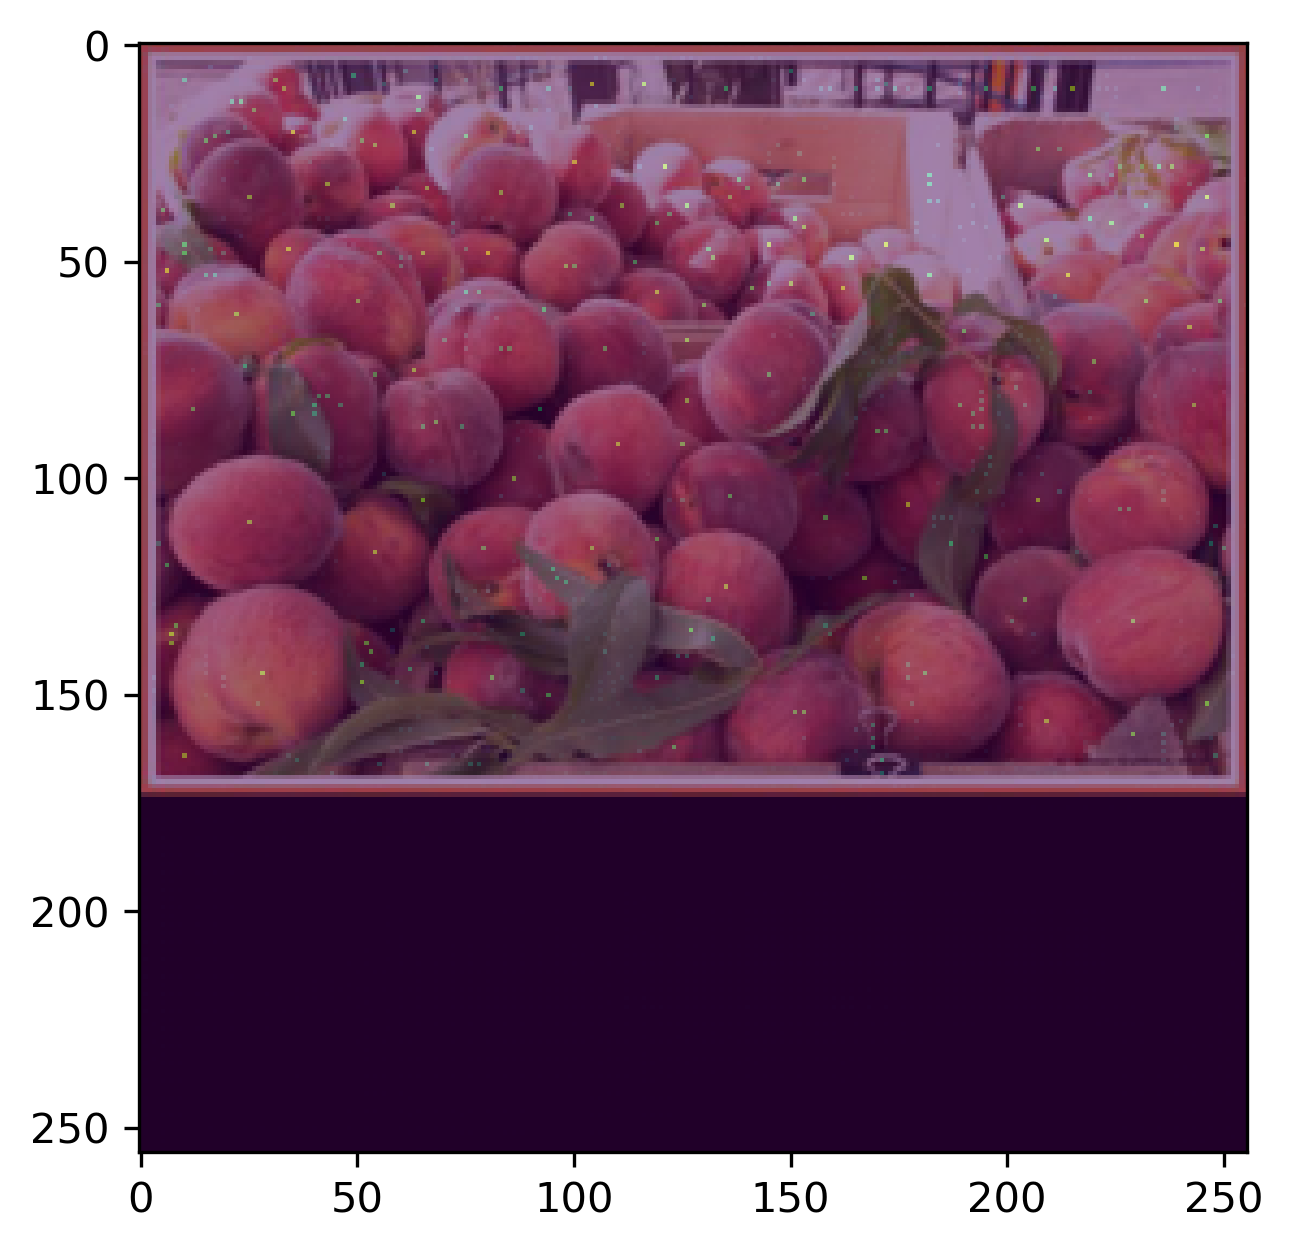

In [26]:
fname = all_image_list['val'][3]
with torch.no_grad():
    point_mask_decoder.max_points = 256
    point_mask_decoder.nms_kernel_size = 3
    point_mask_decoder.point_threshold = 0.05
    outputs = point_mask_decoder(all_data[fname]['features'].cuda())
print(outputs['pred_points'].size())
plt.imshow(read_image(fname).resize((256, 256)))
plt.imshow(outputs['pred_heatmaps_nms'].squeeze().cpu().numpy(), alpha=0.5)

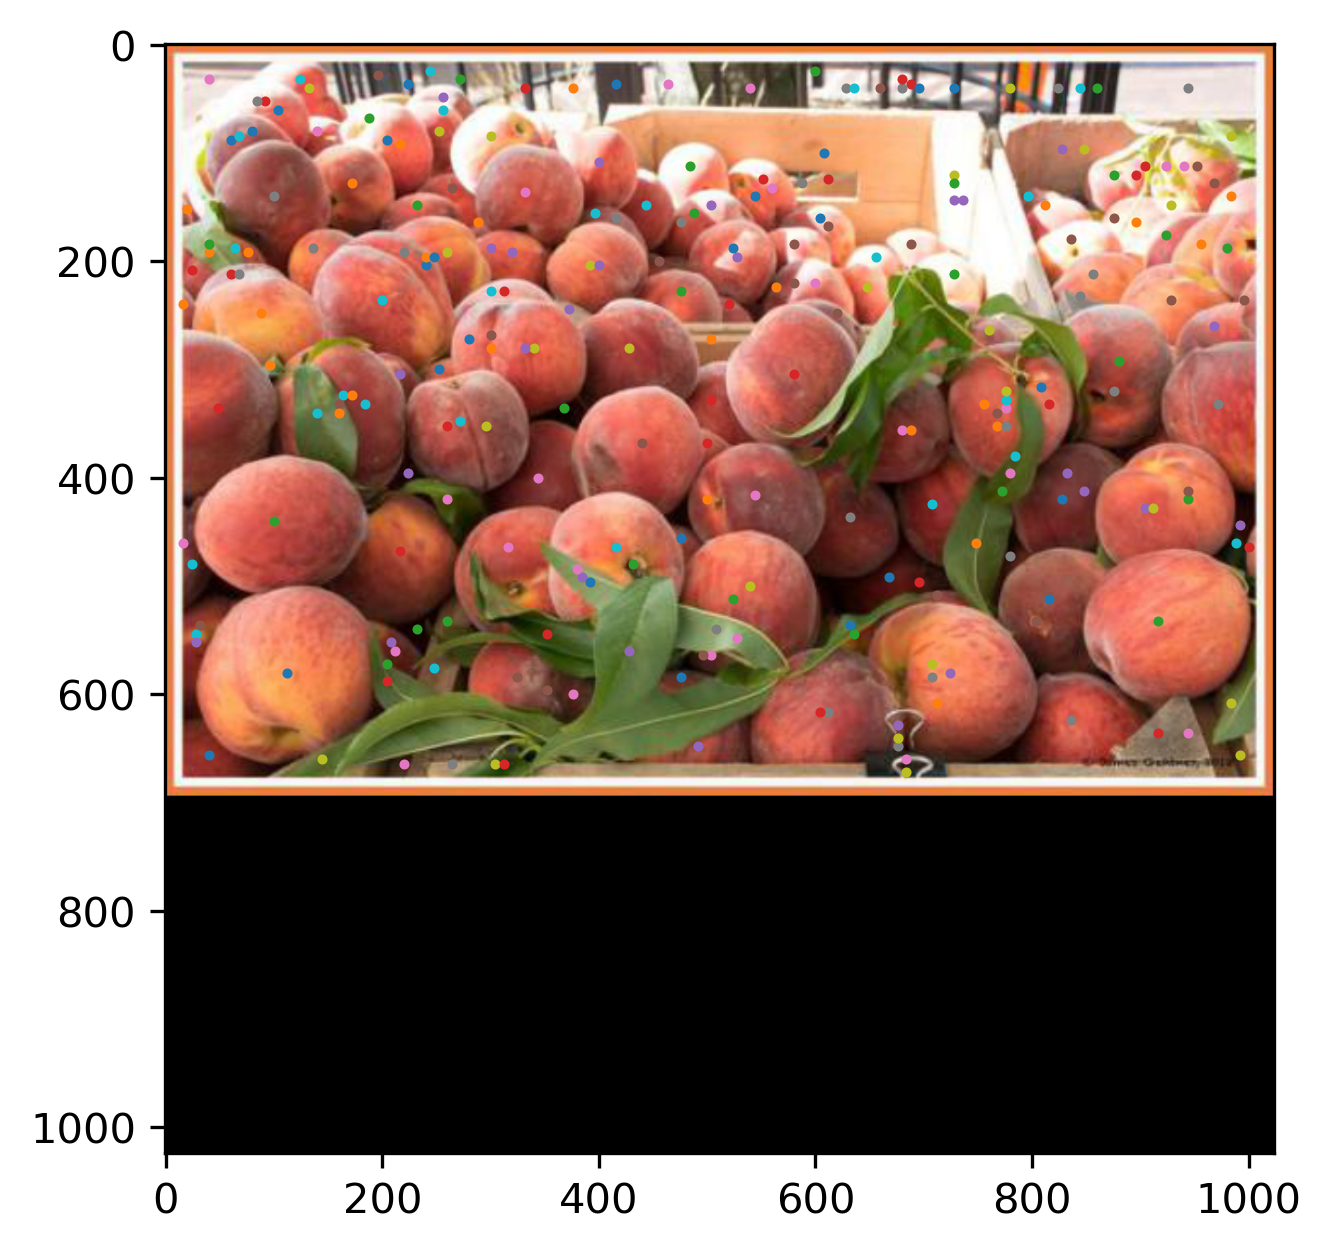

In [31]:
plot_results(read_image(fname),
             points=outputs['pred_points'].squeeze(),
             )